# Laden der Daten und Inspizieren der Daten (kopiert)

In [44]:
%run ./utils/load_data.ipynb

No of images:  290
No of masks:  290
(290, 224, 224, 3)
Loaded 290 images and masks.


# Data augmentation


In [45]:
import import_ipynb
from utils.data_augmentation import augment

augmented_images, augmented_masks = augment(images, masks)

print("Dataset size before augmentation: ", images.shape[0])
print("Dataset size after augmentation:", augmented_images.shape[0])

Dataset size before augmentation:  290
Dataset size after augmentation: 1450


# Beispiele aufzeigen

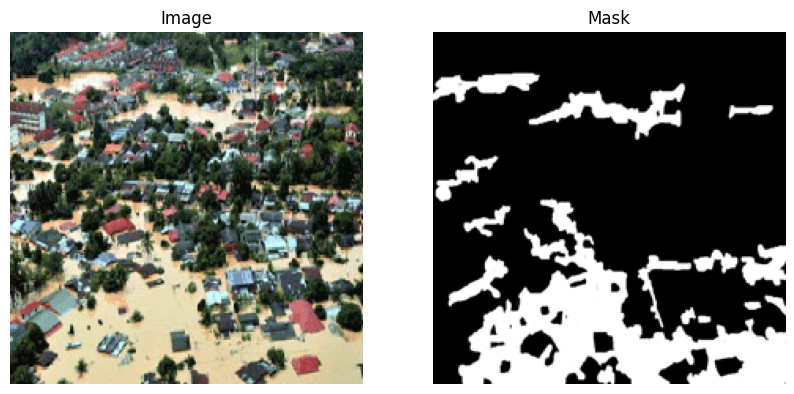

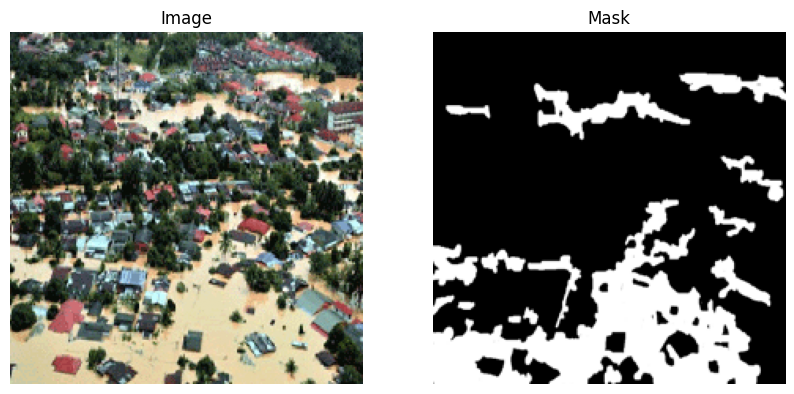

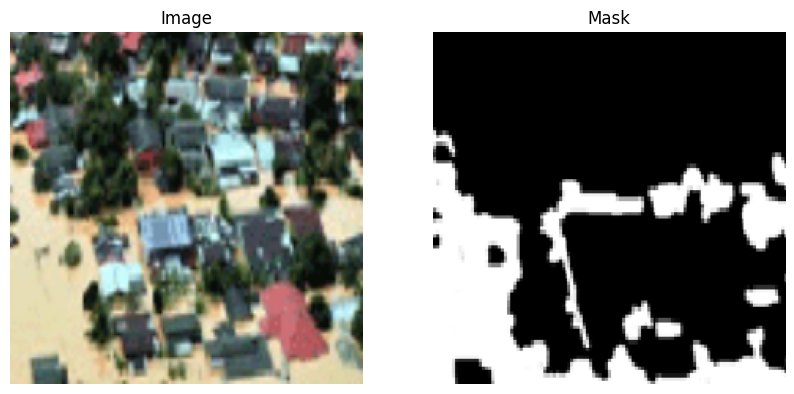

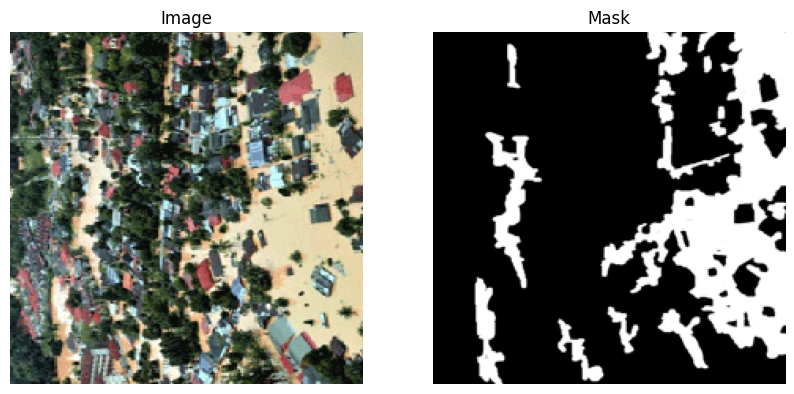

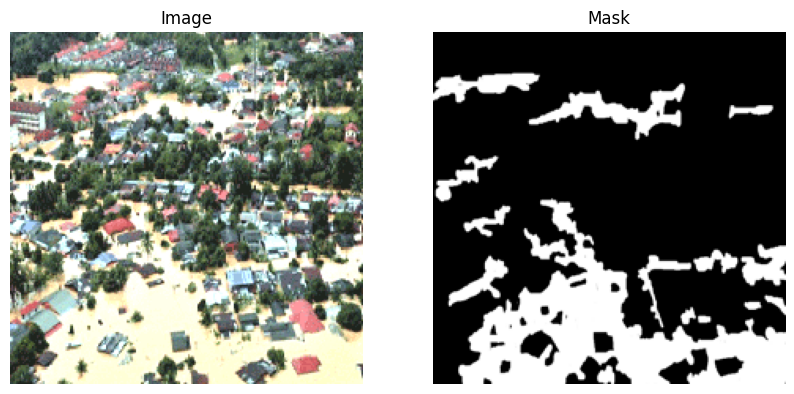

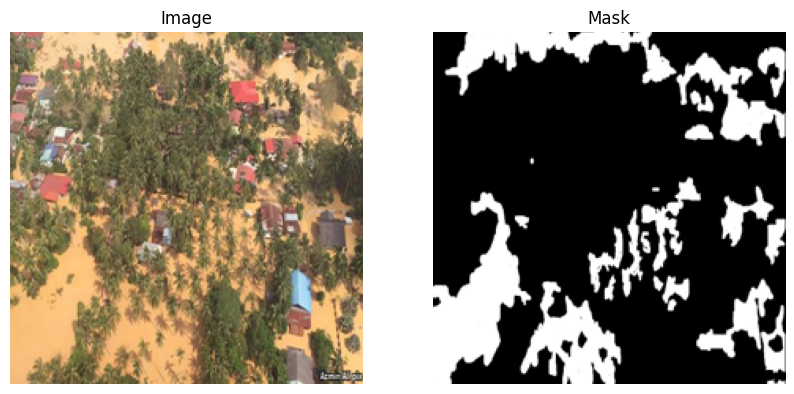

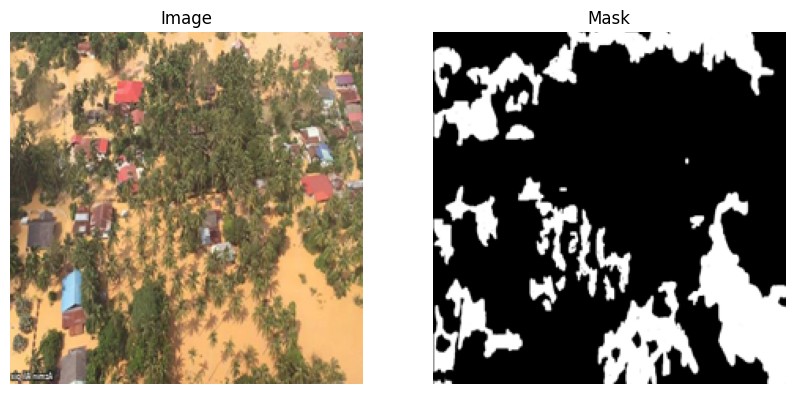

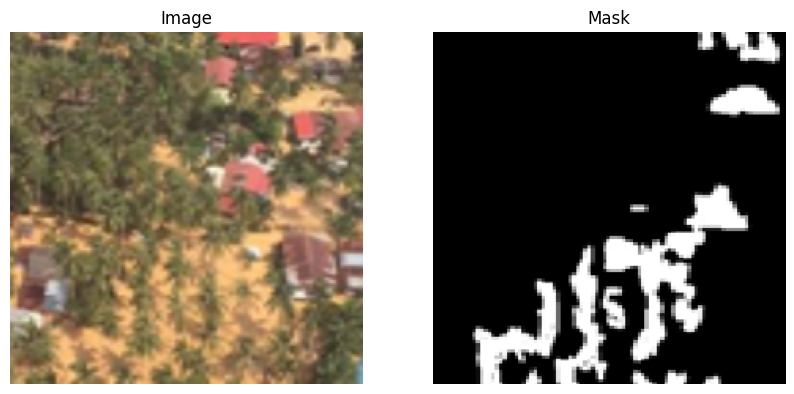

In [46]:
import matplotlib.pyplot as plt

for img, mask in zip(augmented_images[:8], augmented_masks[:8]):
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.title(f"Image")
  plt.imshow(img)
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.title(f"Mask")
  plt.imshow(mask, cmap='gray')
  plt.axis('off')

70% Training
15% Validierung
15% Test

In [47]:
# Train-validation-test split
from sklearn.model_selection import train_test_split

# First split: training set and temporary set (30% goes to temp)
X_train, X_temp, y_train, y_temp = train_test_split(augmented_images, augmented_masks, test_size=0.3, random_state=42)

# Second split: divide temp set into validation and test sets (50% each → 15% each of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset shapes
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (1015, 224, 224, 3)
Val:   (217, 224, 224, 3)
Test:  (218, 224, 224, 3)


#### Tensorflow Speicherwachstum erlauben - verhindert Pre-Allocation

In [48]:
# limit the usage of GPU memory

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Model

In [49]:
import import_ipynb
from utils.iou import iou_metric
from utils.precision_recall_f1 import precision_metric, recall_metric, f1_metric


# from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

In [50]:
from utils.u_net_v1 import unet_model

model = unet_model((IMG_HEIGHT, IMG_WIDTH, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric, precision_metric, recall_metric, f1_metric])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 56, 56,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 112, 112,  │          0 │ conv2d_9[0][0]  

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=BATCH_SIZE
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.5693 - f1_metric: 0.3394 - iou_metric: 0.2450 - loss: 0.6647 - precision_metric: 0.5095 - recall_metric: 0.4372 - val_accuracy: 0.7362 - val_f1_metric: 0.6832 - val_iou_metric: 0.5219 - val_loss: 0.5147 - val_precision_metric: 0.7115 - val_recall_metric: 0.6627
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7444 - f1_metric: 0.7106 - iou_metric: 0.5531 - loss: 0.4936 - precision_metric: 0.7411 - recall_metric: 0.6938 - val_accuracy: 0.7166 - val_f1_metric: 0.5507 - val_iou_metric: 0.3819 - val_loss: 0.6362 - val_precision_metric: 0.8722 - val_recall_metric: 0.4042
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7418 - f1_metric: 0.6888 - iou_metric: 0.5313 - loss: 0.5229 - precision_metric: 0.7754 - recall_metric: 0.6635 - val_accuracy: 0.7740 - val_f1_metric: 0.7551 - val_iou_metric: 0.6086 - val_loss: 0.4446 - val_precision_metric: 0.7301 - val_recall_metric: 0.7886
Epoch 4/50
32/32 

Die Werte der Metrik "Intersection over Union (IoU)" hat sich deutlich verbessert (0.7154 -> 0.8264) auf dem Validation Set. 

## Model speichern

In [57]:
model.save('./trained_models/flood_segmentation_model_data_augmented.keras')

# accuracy: 0.9110 - iou_metric: 0.8624 - loss: 0.1452 - val_accuracy: 0.8890 - val_iou_metric: 0.8264 - val_loss: 0.2256

### Modell und Variablen löschen - Cleanup

In [53]:
# import gc
# import tensorflow as tf
# from keras import backend as K

# # Delete model explicitly
# del model
# K.clear_session()
# tf.keras.backend.clear_session()

# del X_train, X_val, y_train, y_val
# # garbage collection
# gc.collect()

# Diagramme

In [58]:
print(history.history.keys())

dict_keys(['accuracy', 'f1_metric', 'iou_metric', 'loss', 'precision_metric', 'recall_metric', 'val_accuracy', 'val_f1_metric', 'val_iou_metric', 'val_loss', 'val_precision_metric', 'val_recall_metric'])


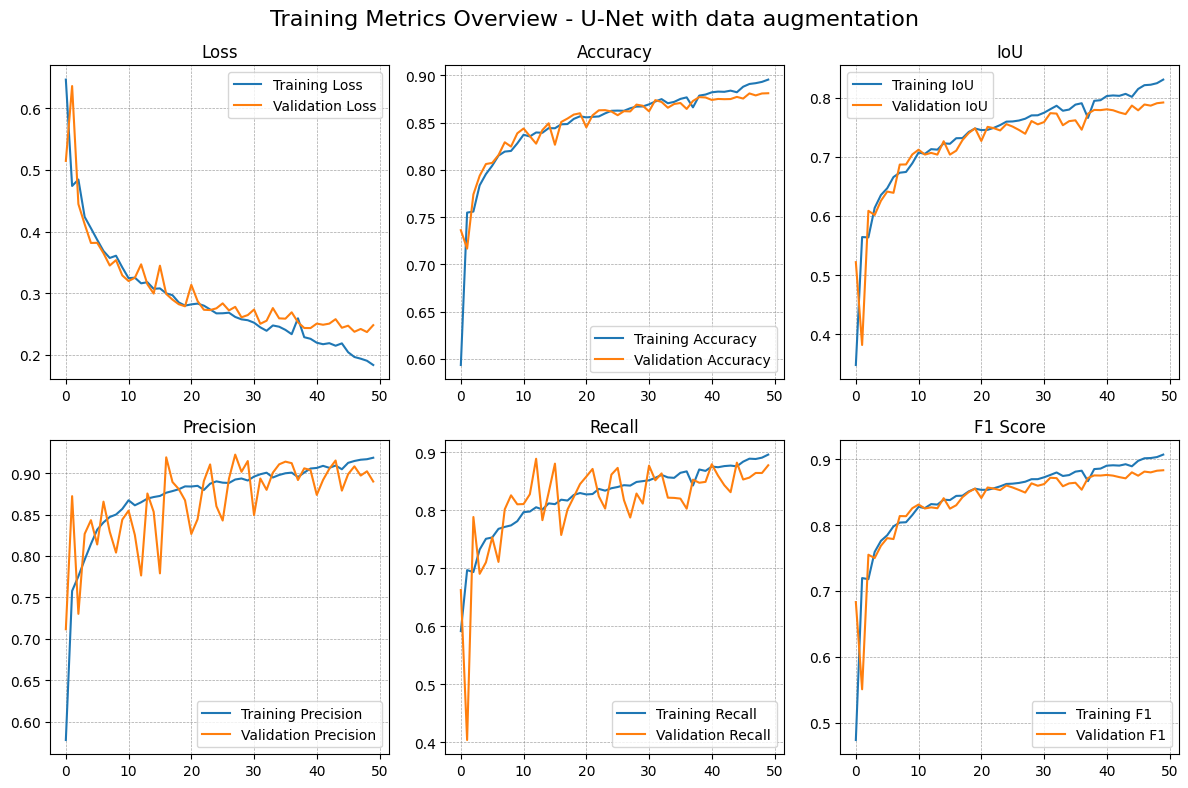

In [65]:
from datetime import datetime

# Plot training history
# Loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Loss')

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Accuracy')

#IoU
plt.subplot(2, 3, 3)
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('IoU')

# Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision_metric'], label='Training Precision')
plt.plot(history.history['val_precision_metric'], label='Validation Precision')
plt.title('Precision')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall_metric'], label='Training Recall')
plt.plot(history.history['val_recall_metric'], label='Validation Recall')
plt.title('Recall')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# F1 Score
plt.subplot(2, 3, 6)
plt.plot(history.history['f1_metric'], label='Training F1')
plt.plot(history.history['val_f1_metric'], label='Validation F1')
plt.title('F1 Score')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

plt.suptitle('Training Metrics Overview - U-Net with data augmentation', fontsize=16)
plt.tight_layout()
plt.savefig(f'./img/training_metrics_data_augmentation_{datetime.now().isoformat()}.png', dpi=300, bbox_inches='tight')
plt.show()

Was zeigen die Plots:

- leichter Overfitting - seit Epoche ~30 sieht man Diskrepanz in Metriken-Werte zwischen Training und Validation Set
  - trotzdem verbessern sich die Werte der Metriken
  - [ ] soll man in diesem Fall weiter Trainieren

### Modell evaluieren mit Testdaten

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Prediction and binarization
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
y_true_binary = (y_test > 0.5).astype(int)

# Flatten
y_true_flat = y_true_binary.flatten()
y_pred_flat = y_pred_binary.flatten()

# Metrics
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
iou = jaccard_score(y_true_flat, y_pred_flat)

# Output
print("\n===== Final Test Evaluation =====")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step

===== Final Test Evaluation =====
Precision: 0.8911
Recall:    0.8789
F1 Score:  0.8850
IoU:       0.7937


# Visualize predictions

In [56]:
import import_ipynb
from utils.iou import iou_metric

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


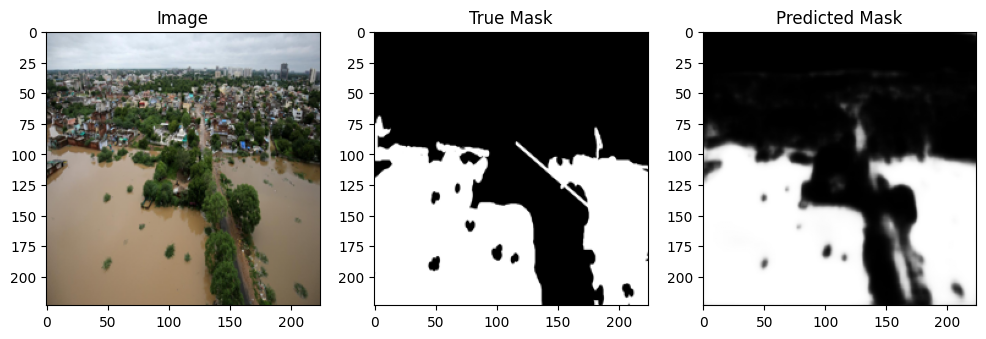

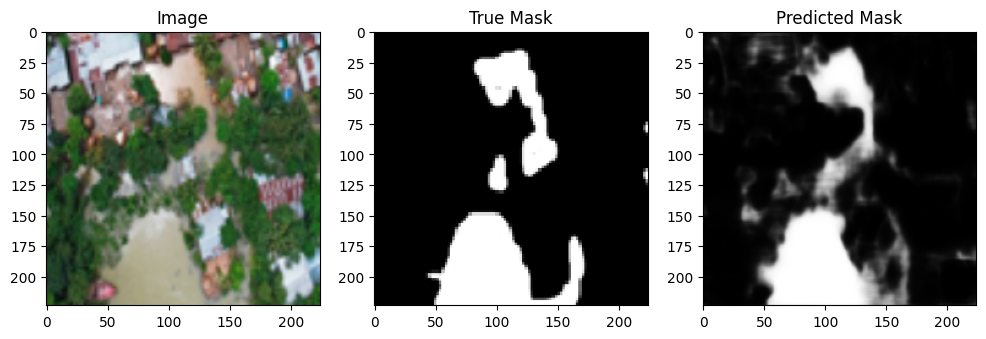

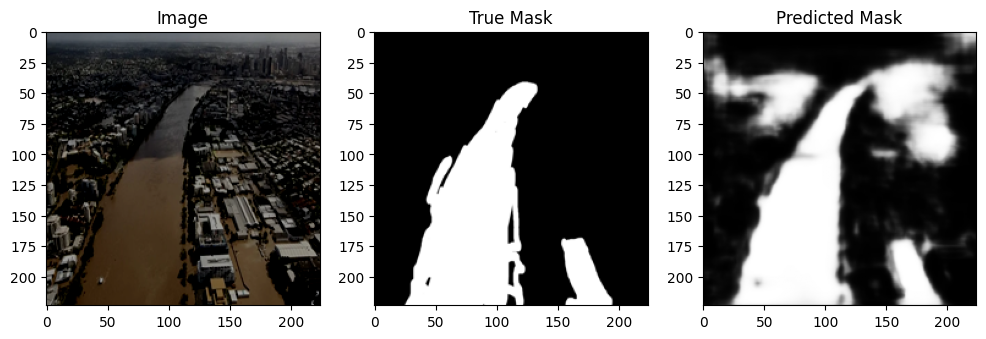

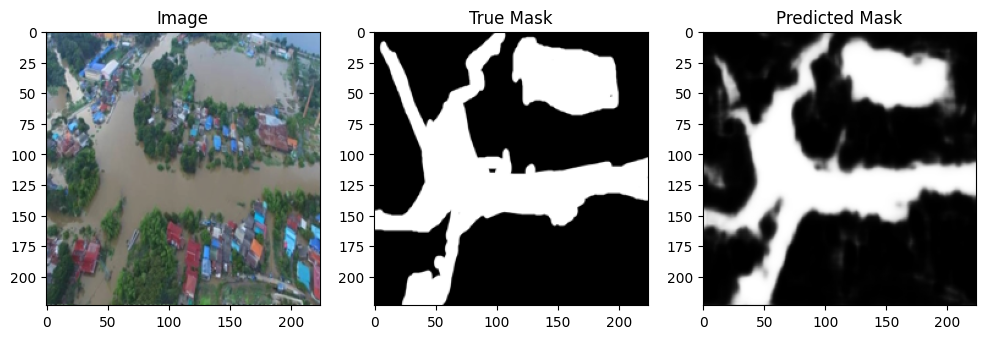

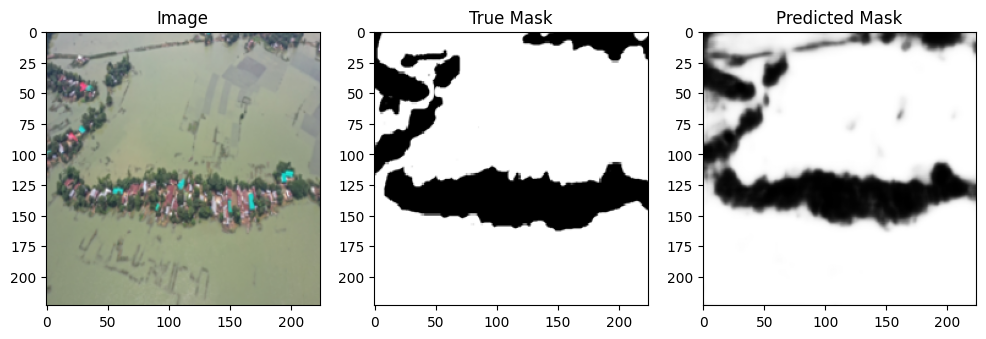

In [61]:
from tensorflow.keras.models import load_model

model = load_model('./trained_models/flood_segmentation_model_data_augmented.keras')

def visualize_predictions(num_images=5):
    preds = model.predict(X_val[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_val[i])

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_val[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='gray')

        plt.show()

visualize_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


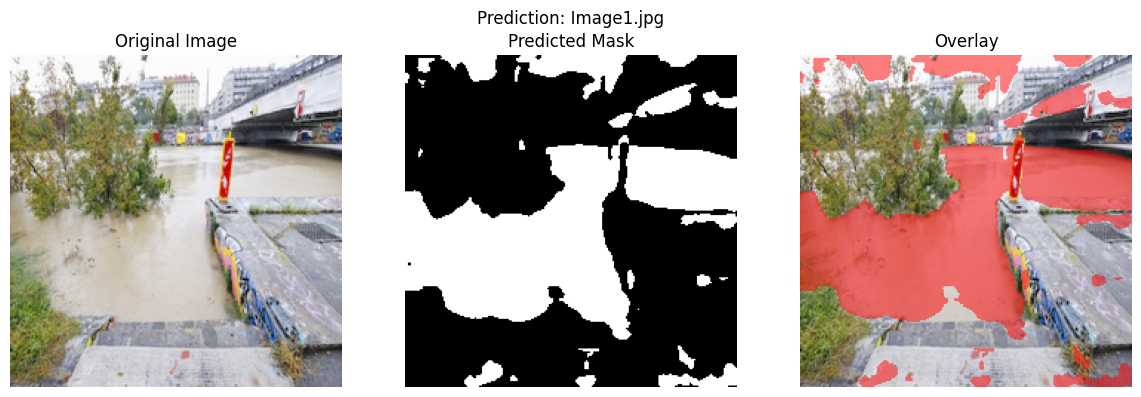

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


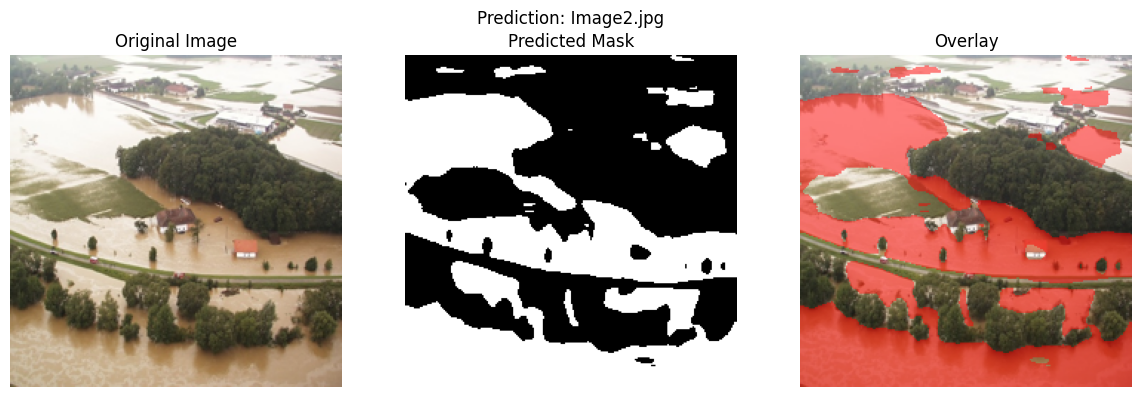

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


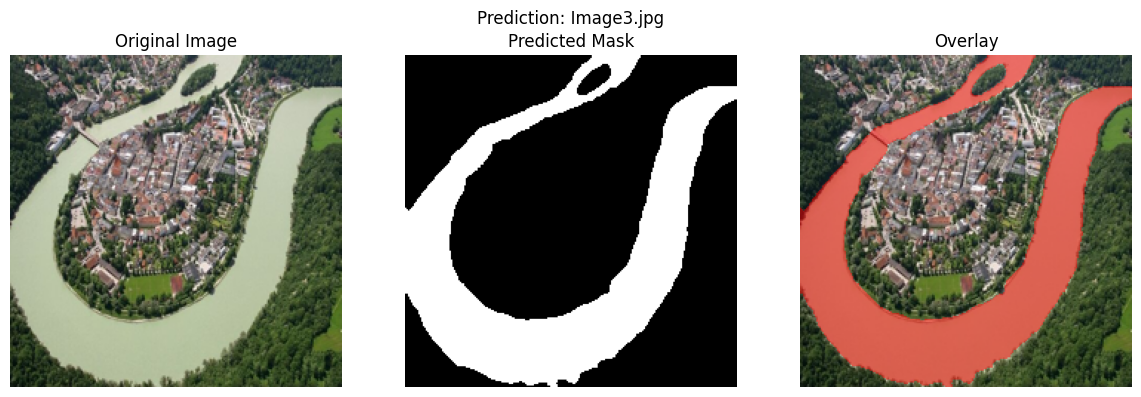

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


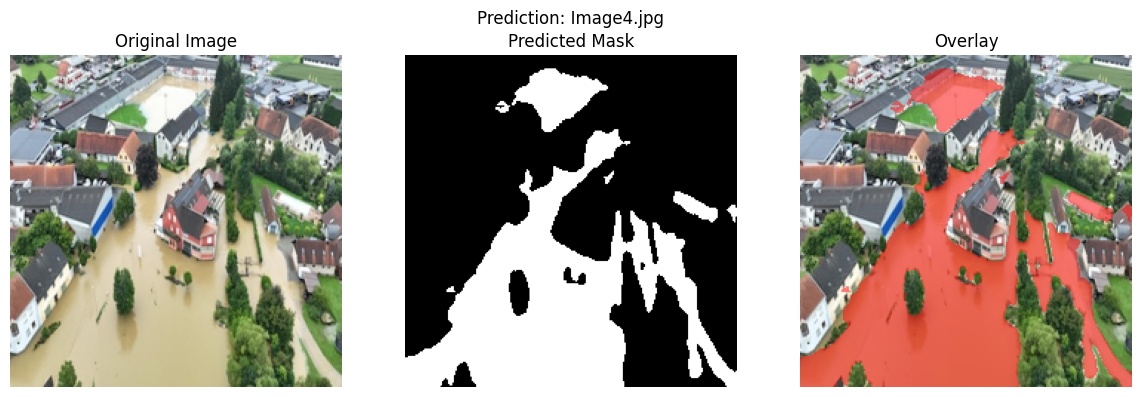

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


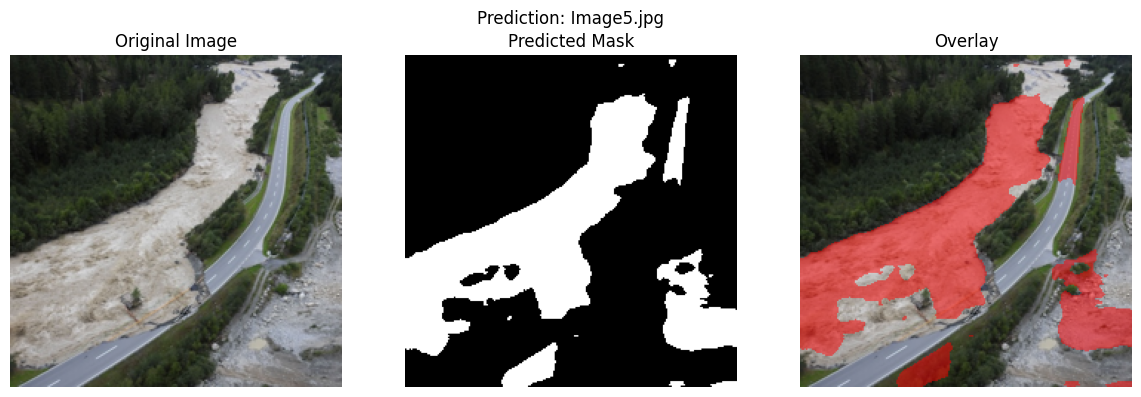

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


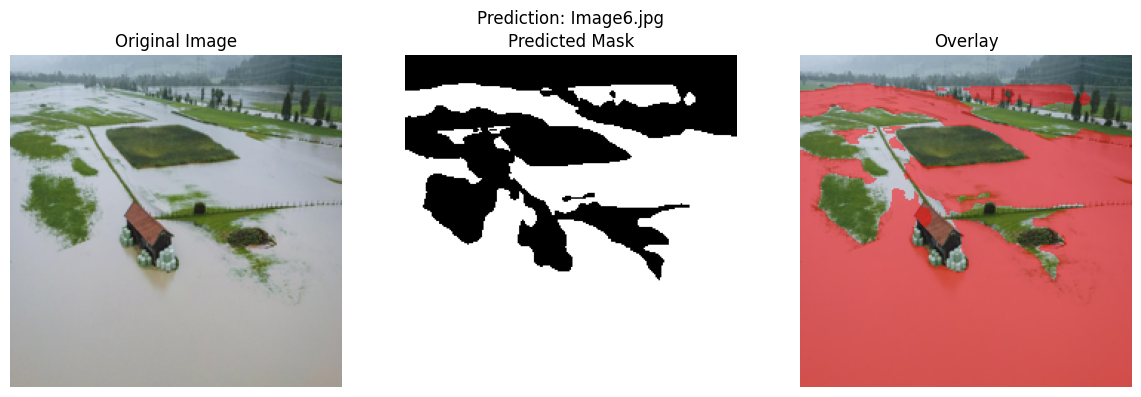

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


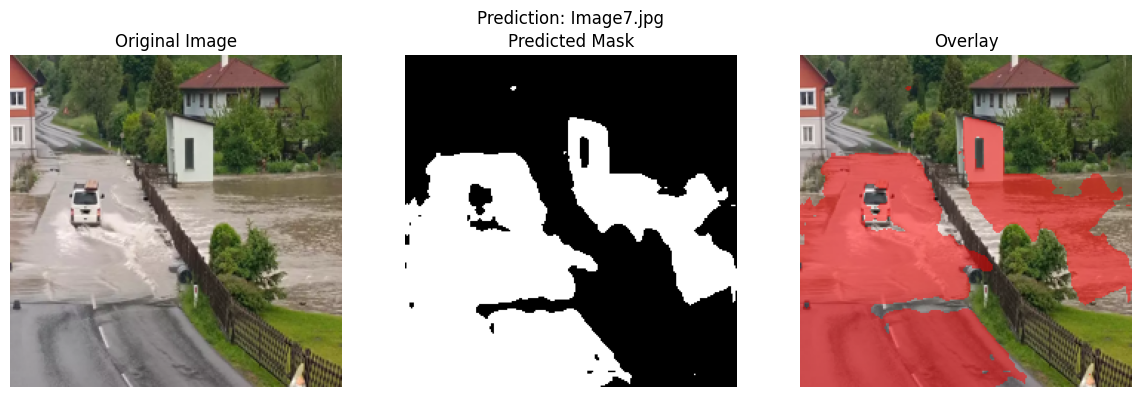

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


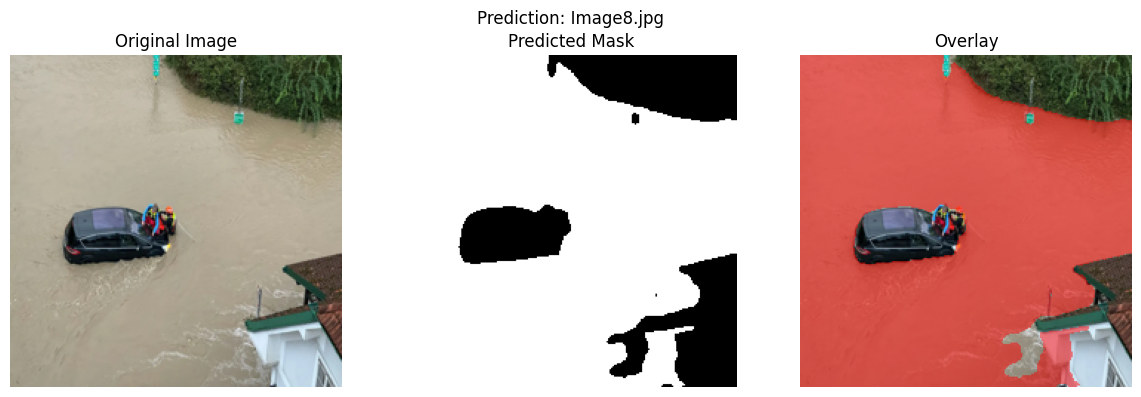

In [63]:
import import_ipynb
from utils.visualize_prediction import visualize_prediction
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model

IMG_HEIGHT, IMG_WIDTH = 224, 224
IMAGE_FOLDER = 'flood_images'  
ALPHA = 0.5  # Transparency of the mask

# load the model
model = load_model('./trained_models/flood_segmentation_model_data_augmented.keras', compile=False)

# use images for predictions
image_files = sorted(os.listdir(IMAGE_FOLDER))
for img_file in image_files:
    img_path = os.path.join(IMAGE_FOLDER, img_file)
    
    # preparation
    image = Image.open(img_path).convert("RGB")
    image_resized = image.resize((IMG_WIDTH, IMG_HEIGHT))
    image_array = np.array(image_resized) / 255.0
    input_tensor = np.expand_dims(image_array, axis=0)  # Shape: (1, H, W, 3)

    # prediction
    pred_mask = model.predict(input_tensor)[0, :, :, 0]  # Shape: (H, W)
    pred_binary = (pred_mask > 0.5).astype(np.uint8)

    visualize_prediction(
    image_resized=np.array(image_resized), 
    pred_binary=pred_binary, 
    img_file=img_file,
    alpha=ALPHA
)